In [96]:
# Built-in modules
import math

# Imports from Qiskit
from qiskit import QuantumCircuit
from qiskit.circuit.library import GroverOperator, MCMT, ZGate
from qiskit.visualization import plot_distribution
from qiskit_aer import *
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
# Imports from Qiskit Runtime
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2 as Sampler

In [97]:
backend = Aer.get_backend('qasm_simulator')
print(backend.name)

qasm_simulator


In [98]:
def grover_oracle(marked_states):
    """Build a Grover oracle for multiple marked states

    Here we assume all input marked states have the same number of bits

    Parameters:
        marked_states (str or list): Marked states of oracle

    Returns:
        QuantumCircuit: Quantum circuit representing Grover oracle
    """
    if not isinstance(marked_states, list):
        marked_states = [marked_states]
    # Compute the number of qubits in circuit
    num_qubits = len(marked_states[0])

    qc = QuantumCircuit(num_qubits)
    # Mark each target state in the input list
    for target in marked_states:
        # Flip target bit-string to match Qiskit bit-ordering
        rev_target = target[::-1]
        # Find the indices of all the '0' elements in bit-string
        zero_inds = [ind for ind in range(num_qubits) if rev_target.startswith("0", ind)]
        # Add a multi-controlled Z-gate with pre- and post-applied X-gates (open-controls)
        # where the target bit-string has a '0' entry
        qc.x(zero_inds)
        qc.compose(MCMT(ZGate(), num_qubits - 1, 1), inplace=True)
        qc.x(zero_inds)
    return qc

In [99]:
def convert_to_bitstring(nums, num_qubits):
    """Convert an integer to a bitstring"""
    for i in range(len(nums)):
        nums[i] = format(nums[i], '0{}b'.format(num_qubits))
    return nums
    # return format(num, '0{}b'.format(num_qubits))

In [100]:
# def grovers_circuit():
#     grover_op = GroverOperator(oracle)
#     optimal_num_iterations = math.floor(
#     math.pi / (4 * math.asin(math.sqrt(len(marked_states) / 2**grover_op.num_qubits)))
#     )
#     qc = QuantumCircuit(grover_op.num_qubits)
# # Create even superposition of all basis states
#     qc.h(range(grover_op.num_qubits))
#     # Apply Grover operator the optimal number of times
#     qc.compose(grover_op.power(optimal_num_iterations), inplace=True)
#     # Measure all qubits
#     qc.measure_all()
#     qc.draw(output="mpl", style="iqp")
#     return qc
def grovers_circuit():
    grover_op = GroverOperator(oracle)
    optimal_num_iterations = math.floor(
    math.pi / (4 * math.asin(math.sqrt(len(marked_states) / 2**grover_op.num_qubits)))
    )
    qc = QuantumCircuit(grover_op.num_qubits)
    # Create even superposition of all basis states
    qc.h(range(grover_op.num_qubits))
    # Apply Grover operator the optimal number of times
    qc.compose(grover_op.power(optimal_num_iterations), inplace=True)
    # Measure all qubits
    qc.measure_all()
    qc.draw(output="mpl", style="iqp")
    return qc

In [101]:
def optimize_grovers(qc):
    target = backend.target
    pm = generate_preset_pass_manager(target=target, optimization_level=3)
    
    circuit_isa = pm.run(qc)
    circuit_isa.draw(output="mpl", idle_wires=False, style="iqp")
    return circuit_isa

{'011': 2874, '000': 2766, '001': 2797, '010': 332, '101': 300, '100': 329, '110': 312, '111': 290}


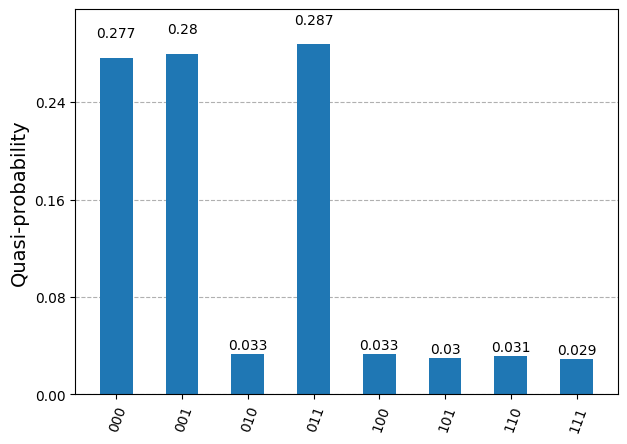

In [102]:
# To run on local simulator:
#   1. Use the SatetvectorSampler from qiskit.primitives instead
# marked_states = convert_to_bitstring(range(8), 4)
marked_states = ["001", "000", "011"]
oracle = grover_oracle(marked_states)
sampler = Sampler(backend)
sampler.options.default_shots = 10_000
grover_circ = grovers_circuit()
# result = sampler.run([grover_circ]).result()
result = sampler.run([optimize_grovers(grover_circ)]).result()
dist = result[0].data.meas.get_counts()
print(dist)
plot_distribution(dist)
# oracle.draw(output="mpl", style="iqp")